In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

'%.4f'

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

Done in 60 seconds
Done in 1669 seconds


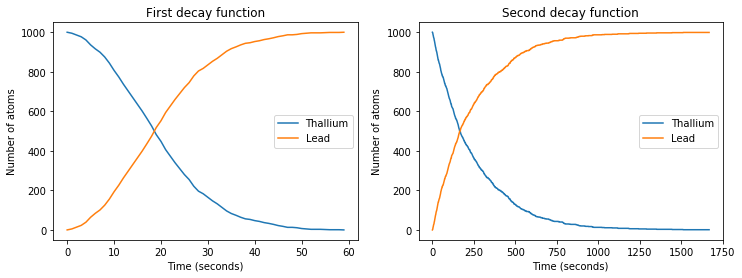

In [2]:
# standard method
TL = 1000
PB = 0
TAU = 3.052 * 60 # half life in seconds

def decay(t):
    return 1-2**(-t/TAU)

sec = 1
hist = [[TL,PB]] # decay history
while TL > 0:
    prob = decay(sec)
    for i in range(TL):
        draw = np.random.uniform(0,1)
        if draw < prob:
            TL -= 1
            PB += 1
    hist.append([TL,PB])
    sec += 1
print('Done in {} seconds'.format(sec))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(hist)
plt.title('First decay function')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of atoms')
plt.legend(['Thallium','Lead'])

# inverse transform method
def pdf(t):
    return 2**(-t/TAU)*np.log(2)/TAU

def cdf(t):
    return 1 - 2**(-t/TAU)

def icdf(p):
    return -np.log2(1-p)*TAU

TL = 1000
PB = 0

# generate decays, apply icdf
decays = np.random.random(size=(TL,))
decays = icdf(decays)
decays.sort()

hist = [[TL,PB]]
limit = int(np.round(decays.max()))
print('Done in {} seconds'.format(limit))
for sec in range(1,limit):
    if TL <= 0: break
    
    # count
    dec = decays[ decays >= sec-1]
    dec = dec[dec < sec]
    cnt = len(dec)

    #cnt = 0 # alternative method
    #for dec in decays:
    #    if dec >= sec-1 and dec <= sec:
    #        cnt += 1
    
    TL -= cnt
    PB += cnt
    hist.append([TL,PB])

plt.subplot(122)
plt.plot(hist)
plt.title('Second decay function')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of atoms')
plt.legend(['Thallium','Lead']);

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [3]:
import scipy.constants as const
Z = 79
E = 7.7e6 * const.e
e = const.e
eps = const.epsilon_0
alfa = const.physical_constants['Bohr radius'][0]
std = alfa/100

def theta():
    b = ( -2*(std**2) * np.log(1-np.random.rand()) )**0.5
    return 2*np.arctan( (Z*e**2)/(2*np.pi*eps*E*b) )

particles = int(1e6)
thr = np.pi/2

res = [1 for _ in range(particles) if theta() > thr]

# alternative way, same output
#for _ in range(particles):
#    if theta() > thr:
#        res += 1

frac = np.sum(res)/particles

print("Bounced back fraction: {}".format(frac))

Bounced back fraction: 0.00156


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [4]:
from scipy import integrate
def f(x):
    return (np.sin(1/(x*(2-x))))**2

# real integral value
x = np.linspace(0.001,1.999,1000)
realIntValue = integrate.quad(f,0,2)[0]
print("Real integral value:", realIntValue)

# MC integration, hit-miss
# get random value and accept if above
N = 100000
count = 0
for i in range(N):
    x = 2*np.random.random() # 0-2 range
    y = np.random.random()
    if y < f(x):
        count += 1
intValue = 2*count/N
print('Integral value: ',intValue,
      '\t\tError: ', abs(realIntValue-intValue))

# mean value method
# get random values in [0,2] and apply function
values = 2*np.random.random(N)
values = f(values)
meanIntValue = 2*values.sum()/N
print('Integral value: ',meanIntValue,
      '\tError: ', abs(realIntValue-meanIntValue))

Real integral value: 1.4516877509810684


C:\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Integral value:  1.45414 		Error:  0.002452249018931596
Integral value:  1.4511573360889358 	Error:  0.0005304148921325691


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [5]:
def f(x,r):
    sqsum = sum([i**2 for i in x])
    return int(sqsum <= r) # 1==True,0==False

def integ(dim, rad=1.0):
    N = 100000
       
    # apply function to N vector, each of dim random coordinates
    values = [f(np.random.rand(dim), rad) for _ in range(N)]
    
    # same result is obtained using:
    #values = np.zeros(N)
    #for i in range(N):
    #    vec = np.random.rand(dim)
    #    values[i] = f(vec,rad)
        
    return 2**dim*np.sum(values)/N
    # return 4*(b-a)*values.sum()/N # valid if dim==2 (b=1,a=0)

circleInt = integ(2)
circleRealInt = np.pi # by math
sphereInt = integ(10)
sphereRealInt = np.pi**5/120 # by math

print("Circle int. value: {}, real: {}, error: {}".format(circleInt, circleRealInt, np.abs(circleRealInt-circleInt)))
print("Sphere int. value: {}, real: {}, error: {}".format(sphereInt, sphereRealInt, np.abs(sphereRealInt-sphereInt)))

Circle int. value: 3.14044, real: 3.141592653589793, error: 0.0011526535897932177
Sphere int. value: 2.75456, real: 2.550164039877345, error: 0.20439596012265504


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [6]:
def f(x):
    return x**(-0.5)/(np.exp(x)+1)

def w(x):
    return x**(-0.5)

def w_itg(a,b):
    # integral of w, using scipy
    return integrate.quad(w,a,b)[0]

def integ(N, a=0.0, b=1.0):
    itg = w_itg(a,b)
    
    res = 0.0
    for i in range(N):
        x = np.random.rand()
        res += f(x)/w(x)
    return res*itg/N # itg can be collected in the summation

# generate values
N = int(1e6)
print("Integral value: ",integ(N))

Integral value:  0.7595936122853074
